# Чтение данных

In [1]:
import os

import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
PATH = "../"

In [3]:
df = pd.read_csv(os.path.join(PATH, "train.csv"))
test = pd.read_csv(os.path.join(PATH, "test.csv"))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48665 entries, 0 to 48664
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rate    48665 non-null  int64 
 1   text    48665 non-null  object
dtypes: int64(1), object(1)
memory usage: 760.5+ KB


# Нормализация id класса

In [5]:
label_encoder = LabelEncoder()
df.rate = label_encoder.fit_transform(df.rate)
df.head()

,rate,text
0,3,Очень понравилось. Были в начале марта с соба...
1,4,В целом магазин устраивает.\nАссортимент позво...
2,4,"Очень хорошо что открылась 5 ка, теперь не над..."
3,2,Пятёрочка громко объявила о том как она заботи...
4,2,"Тесно, вечная сутолока, между рядами трудно ра..."


# Предобработка

In [7]:
import re
from pymorphy3 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation
from tqdm import tqdm

In [8]:
tqdm.pandas()

In [ ]:
exclude = set(punctuation)
sw = set(get_stop_words("ru"))
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in exclude]
    return " ".join(txt)

In [9]:
df['text_clear'] = df['text'].progress_apply(preprocess_text)

100%|██████████| 48665/48665 [02:43<00:00, 296.82it/s]


In [10]:
df.head()

,rate,text,text_clear
0,3,Очень понравилось. Были в начале марта с соба...,очень понравиться быть в начало март с собака ...
1,4,В целом магазин устраивает.\nАссортимент позво...,в целое магазин устраивать ассортимент позволя...
2,4,"Очень хорошо что открылась 5 ка, теперь не над...",очень хорошо что открыться 5 ка теперьня надо ...
3,2,Пятёрочка громко объявила о том как она заботи...,пятёрочка громко объявить о тот как она заботи...
4,2,"Тесно, вечная сутолока, между рядами трудно ра...",тесно вечный сутолока между ряд трудно разойти...


# Создание векторов документов

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), max_features=5000)

features = tfidf.fit_transform(df.text_clear).toarray()
labels = df.rate
features.shape

(48665, 5000)

# Корреляция терминов с метками

In [11]:
id_to_rate = ['отвратительный', 'хороший', 'маленький', 'неплохой', 'отличный']

In [19]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for i in range(0, 5):
    features_chi2 = chi2(features, labels == i)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("Label '{}':".format(i))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

Label '0':
  . Most correlated unigrams:
       . отвратительный
       . ужасный
  . Most correlated bigrams:
       . отвратительный магазин
       . ужасный магазин
Label '1':
  . Most correlated unigrams:
       . грязно
       . хороший
  . Most correlated bigrams:
       . хороший магазин
       . единственный плюс
Label '2':
  . Most correlated unigrams:
       . хороший
       . маленький
  . Most correlated bigrams:
       . маленький ассортимент
       . хороший магазин
Label '3':
  . Most correlated unigrams:
       . обычный
       . но
  . Most correlated bigrams:
       . обычный магазин
       . отличный магазин
Label '4':
  . Most correlated unigrams:
       . хороший
       . отличный
  . Most correlated bigrams:
       . отличный магазин
       . хороший магазин


# Cross validation

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df.text, df.rate, random_state=96)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [22]:
test.head()

,index,text
0,0,Очень хороший магазин и сотрудники приятный
1,1,"Самый обычный продуктовый магазин. Есть сыры,..."
2,2,Всё хорошо и комфортно
3,3,"Маленький филиальчик, все необходимое есть. Дв..."
4,4,Плохо относятся к клиентам!!!!!\n


In [23]:
i = clf.predict(count_vect.transform(["Плохо относятся к клиентам!!!!!\n"]))
id_to_rate[i[0]]

'отличный'

In [24]:
i = clf.predict(
    count_vect.transform(["Маленький филиальчик, все необходимое есть. Две кассы, если народу много, можно застрять."]))
id_to_rate[i[0]]

'отличный'

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


In [29]:

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\prj\ods\nlp_huawei_new2_task\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\prj\ods\nlp_huawei_new2_task\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\prj\ods\nlp_huawei_new2_task\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\prj\ods\nlp_huawei_new2_task\venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\prj\ods\n

In [30]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.535703
1,RandomForestClassifier,1,0.535601
2,RandomForestClassifier,2,0.535703
3,RandomForestClassifier,3,0.535703
4,RandomForestClassifier,4,0.535703
5,LinearSVC,0,0.625193
6,LinearSVC,1,0.622624
7,LinearSVC,2,0.630946
8,LinearSVC,3,0.628275
9,LinearSVC,4,0.632385


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

NameError: name 'cv_df' is not defined

In [35]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.627885
LogisticRegression        0.649399
MultinomialNB             0.630350
RandomForestClassifier    0.535683
Name: accuracy, dtype: float64

# Обучение на выбранной модели

In [14]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index,
                                                                                 test_size=0.33, random_state=0,
                                                                                 verbose=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\prj\ods\nlp_huawei_new2_task\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


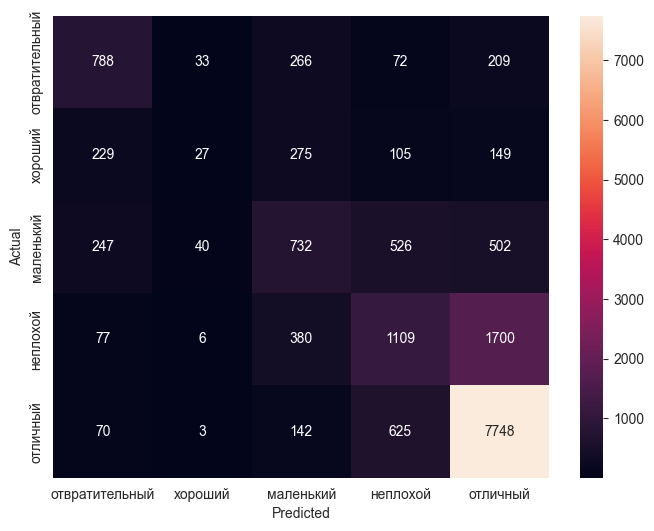

In [17]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=id_to_rate, yticklabels=id_to_rate)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=id_to_rate))

                precision    recall  f1-score   support

отвратительный       0.56      0.58      0.57      1368
       хороший       0.25      0.03      0.06       785
     маленький       0.41      0.36      0.38      2047
      неплохой       0.46      0.34      0.39      3272
      отличный       0.75      0.90      0.82      8588

      accuracy                           0.65     16060
     macro avg       0.48      0.44      0.44     16060
  weighted avg       0.61      0.65      0.62     16060


# Тест

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12167 entries, 0 to 12166
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   12167 non-null  int64 
 1   text    12167 non-null  object
dtypes: int64(1), object(1)
memory usage: 190.2+ KB


## Предобработка

In [20]:
test['text_clear'] = test['text'].progress_apply(preprocess_text)

100%|██████████| 12167/12167 [00:40<00:00, 299.13it/s]


## Word2vec

In [34]:
# features1 = tfidf.fit_transform(test.text_clear).toarray()
features1 = tfidf.fit_transform(test.text_clear)
features1.shape

(12167, 5000)

## Предсказания

In [35]:
features1[0].shape

(1, 5000)

In [37]:
test['label'] = model.predict(features1)

In [38]:
test.head()

,index,text,text_clear,label,rate
0,0,Очень хороший магазин и сотрудники приятный,очень хороший магазин и сотрудник приятный,4,5
1,1,"Самый обычный продуктовый магазин. Есть сыры,...",самый обычный продуктовый магазин есть сыр кол...,4,5
2,2,Всё хорошо и комфортно,всё хорошо и комфортно,4,5
3,3,"Маленький филиальчик, все необходимое есть. Дв...",маленький филиальчик всенеобходимый есть два к...,4,5
4,4,Плохо относятся к клиентам!!!!!\n,плохо относиться к клиент,4,5


## Обратная перекодировка

In [24]:
test['rate'] = label_encoder.inverse_transform(test.label)

## Создание тестового набора 

In [27]:
submission = test[['index', 'rate']]
submission

,index,rate
0,0,5
1,1,5
2,2,5
3,3,5
4,4,5
...,...,...
12162,12162,5
12163,12163,5
12164,12164,1
12165,12165,5


In [28]:
submission.to_csv('submission.csv', index=False)


> 0,3935557275	
